# Apply NORDic to the ``toy_reprogramming_1`` synthetic dataset

In [1]:
import NORDic
from IPython.display import Image
import pandas as pd

dataset_name = "toy_reprogramming_1"
pert_genes = ["G8UPG1", "TF1", "TF1KOTF2", "TF2", "TF5", "TF7"]

file_folder=f"{dataset_name}/"
seed_number=123456

In this case, we directly have access to binarized (Boolean) trajectories from an initial state to a single steady state (plus intermediary states, that will be ignored) for several synthetic KO experiments.

Let's convert this into a NORDic-compatible format.


## 0. Retrieve the data

In [2]:
import os
from subprocess import Popen

proc = Popen(f"mkdir -p {file_folder}".split(" "))
proc.wait()

data_url="https://raw.githubusercontent.com/gt-bioss/benchmark-dynamical-models/main/"
data_url+=f"from-boolean-networks/{dataset_name}/ground-truth/"

exp_list = ["wt-boolean-trajectories.csv"]+[
    "%sKO-boolean-trajectories.csv" % g
    for g in pert_genes
]

for exp in exp_list:
    proc = Popen(f"wget -O {file_folder}/{exp} -q {data_url}/{exp}".split(" "))
    proc.wait()
    df = pd.read_csv(f"{file_folder}/{exp}", sep=",", index_col=0)
    print(exp)
    print(df.head())
    gene_lst = list(df.columns)

wt-boolean-trajectories.csv
                   G1  G2  G3  G4  G5  G6  G7  G8  G9  TF1  TF2  TF3  TF4  \
init                0   0   0   0   0   0   1   1   1    0    0    0    0   
init_to_switch1_1   0   0   0   0   0   0   1   1   1    0    0    0    0   
init_to_switch1_2   0   0   0   0   0   0   0   1   1    0    0    0    0   
init_to_switch1_3   0   0   0   0   0   0   0   0   1    0    0    0    0   
init_to_switch1_4   0   0   0   0   0   0   0   0   0    0    0    0    0   

                   TF5  TF6  TF7  
init                 0    1    1  
init_to_switch1_1    0    0    1  
init_to_switch1_2    0    0    1  
init_to_switch1_3    0    0    1  
init_to_switch1_4    0    0    1  
G8UPG1KO-boolean-trajectories.csv
                   G1  G2  G3  G4  G5  G6  G7  G8  G9  TF1  TF2  TF3  TF4  \
init                0   0   0   0   0   0   1   1   1    0    0    0    0   
init_to_switch1_1   0   0   0   0   0   0   1   1   1    0    0    0    0   
init_to_switch1_2   0   0   0   0 

## 1. Prior Knowledge Network

The dataset is synthetic, so there is no prior on the structure of the network. We then build a complete graph (to prevent the resort to the STRING database which will be otherwise useless).

In [3]:
NETWORK_fname = f"{file_folder}/complete_ppi.tsv"

tf_tf = [(g,gp) for g in gene_lst for gp in gene_lst if ("TF" in g and "TF" in gp)]
tf_g = [(g,gp) for g in gene_lst for gp in gene_lst if ("TF" in g and "G" in gp)]
n = len(tf_tf)+len(tf_g)
PPI = pd.DataFrame([
    [g, gp, 2, 0, 0.5] ## build undirected unsigned edges for TF-TF with score=0.5
    for g, gp in tf_tf
]+[
    [g, gp, 1, 1, 0.5] ## build directed positive edges for TF->G with score=0.5
    for g, gp in tf_g
], columns=["preferredName_A", "preferredName_B", "sign", "directed", "score"], index=range(n))
PPI.to_csv(NETWORK_fname, sep="\t", index=None)

PPI.head()

,preferredName_A,preferredName_B,sign,directed,score
0,TF1,TF1,2,0,0.5
1,TF1,TF2,2,0,0.5
2,TF1,TF3,2,0,0.5
3,TF1,TF4,2,0,0.5
4,TF1,TF5,2,0,0.5


## 2. Experimental file

We convert the Boolean trajectories that we retrieved into a format compatible with NORDic. For each retrieved experimental file (corresponding to a single (non)perturbation experiment):

- There is the Boolean state of the initial condition named ``init``
- We ignore intermediary states named ``init_to_steady1_*``
- There is the final steady state named ``steady1``

In [4]:
EXPERIMENTS_fname = f"{file_folder}/experiments.csv"
experiments = pd.DataFrame([], index=gene_lst+["annotation", "perturbed", "perturbation", "cell_line", "sigid"])
cell="".join(dataset_name.split("_")) ## no "_"

for ie, exp in enumerate(exp_list):
    df = pd.read_csv(f"{file_folder}/{exp}", sep=",", index_col=0)
    if ("wt-" in exp):
        experiments[f"initial_{cell}"] = df.loc["init"][gene_lst].values.flatten().tolist()+["1","None","None",cell,f"{exp}:init"]
        continue
    if ((len(exp.split("KO"))>2) or ("UP" in exp)):
        continue
    else:
        pert_gene = exp.split("KO")[0]
        pert_dir = "KD"
    exp_name = f"{pert_gene}_KD_"+cell
    steady_name = "steady" if ("steady" in df.index) else "steady1"
    experiments[exp_name] = df.loc[steady_name][gene_lst].values.flatten().tolist()+["2",pert_gene,pert_dir,cell,f"{exp}:steady"]
experiments.to_csv(EXPERIMENTS_fname, sep=",")

experiments.T.head()

,G1,G2,G3,G4,G5,G6,G7,G8,G9,TF1,...,TF3,TF4,TF5,TF6,TF7,annotation,perturbed,perturbation,cell_line,sigid
initial_toyreprogramming1,0,0,0,0,0,0,1,1,1,0,...,0,0,0,1,1,1,None,None,toyreprogramming1,wt-boolean-trajectories.csv:init
TF1_KD_toyreprogramming1,0,0,0,1,1,1,0,0,0,0,...,1,1,1,0,1,2,TF1,KD,toyreprogramming1,TF1KO-boolean-trajectories.csv:steady
TF2_KD_toyreprogramming1,1,1,1,0,0,0,0,0,0,1,...,1,1,1,0,1,2,TF2,KD,toyreprogramming1,TF2KO-boolean-trajectories.csv:steady
TF5_KD_toyreprogramming1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,TF5,KD,toyreprogramming1,TF5KO-boolean-trajectories.csv:steady
TF7_KD_toyreprogramming1,0,0,0,0,0,0,1,1,1,0,...,0,0,0,1,0,2,TF7,KD,toyreprogramming1,TF7KO-boolean-trajectories.csv:steady


## 3. Parameters

Not needed, since both the PKN and the experiments are available from the start.

In [5]:
from multiprocessing import cpu_count
njobs=1

## Random
taxon_id=1111
disease_cids=["Unknown"] 
cell_lines=[cell]
path_to_genes=None

DisGeNET_credentials = ""
STRING_credentials = ""
LINCS_credentials = ""
DISGENET_args = {"credentials": DisGeNET_credentials, "disease_cids": disease_cids}
STRING_args = {"credentials": STRING_credentials, "score": 0}
EDGE_args = {"tau": None, "filter": False, "connected": False}
accept_nonRNA=True
preserve_network_sign=False
LINCS_args = {"path_to_lincs": "", 
              "credentials": LINCS_credentials,
              "cell_lines": cell_lines, "thres_iscale": None}
SIG_args = {"bin_thres": 0.5}
force_experiments=False
DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1}

## Identification parameters
BONESIS_args = {"limit": 1, "exact": False, "max_maxclause": 10}

## 4. Network identification

In [6]:
from NORDic.NORDic_NI.functions import network_identification

solution = NORDic.NORDic_NI.functions.network_identification(
    file_folder, taxon_id, path_to_genes=path_to_genes, disgenet_args=DISGENET_args, 
    string_args=STRING_args, lincs_args=LINCS_args, edge_args=EDGE_args, sig_args=SIG_args,
    bonesis_args=BONESIS_args, weights=DESIRABILITY, experiments_fname=EXPERIMENTS_fname,
    seed=seed_number, network_fname=NETWORK_fname, njobs=njobs, force_experiments=force_experiments, 
    accept_nonRNA=accept_nonRNA, preserve_network_sign=preserve_network_sign)

--- DATA IMPORT ---
1. Import gene set from DisGeNET... ... 16 genes imported.
2. Import network from toy_reprogramming_1//complete_ppi.tsv... ... 112 edges in model (including 63 directed edges) with a total of 16 non-isolated genes
3. Import experiments from toy_reprogramming_1//experiments.csv... 
	1 cell lines are considered (['toyreprogramming1'])
... 16 genes in 5 profiles (5 experiments)

--- CONSTRAINT BUILDING ---
1. Filtering out edges by minimum set of edges with highest score which preserve connectivity... ... 112 unique edges involving genes both in experiments (16 genes in total)
... score_STRING 0.000000	16 genes (non isolated in PPI)	259 edges in PPI
2. Build topological constraints from filtered edges using gene expression data...  ...... 14 negative, 98 positive undirected interactions (112 edges in total), 16 non isolated genes in experiments
3. Build dynamical constraints by binarization of experimental profiles...  ...... 4 experiments on 1 cell lines and 16/16 gen

  0%|                                                                                                        | 0/1 [00:00<?, ?it/s]

Grounding...done in 0.2s
Found 1 solutions in 0.2s (first in 0.2s; rate 0.2s)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]

--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...

1 solutions (1 unique solutions)
... 1 solutions (1/17 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 15 edges
<MODEL VISUALIZATION> Maximal solution: 15 edges
            1
GTP  0.856166
<MODEL SELECTION> Saving optimal model in 'toy_reprogramming_1//solution.bnet' ...
G1, TF1
G2, TF1
G3, TF1
G4, TF2
G5, TF2
...
... saved!


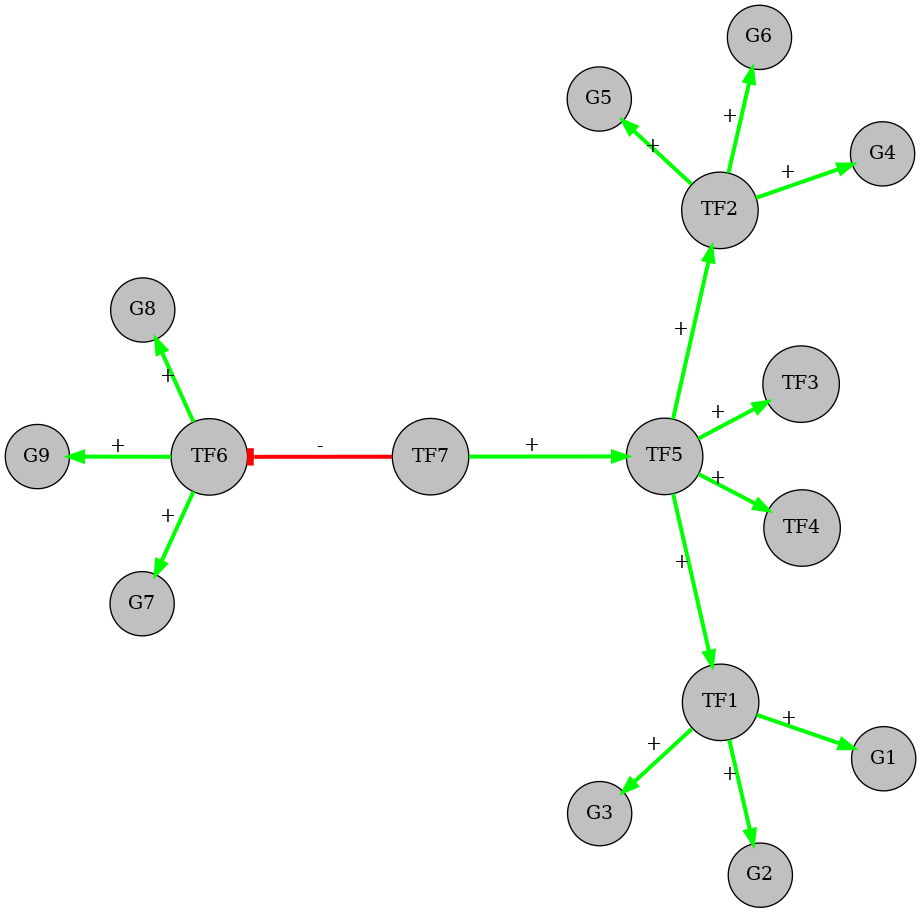

In [7]:
from IPython.display import Image
Image(filename=f'{file_folder}/inferred_max_criterion_solution.png') 

In [8]:
pd.read_csv(f"{file_folder}/GPT.csv", index_col=0).T.sort_values(by="GTP", ascending=False)

,GTP
1,0.856166


## 5. Ground truth network

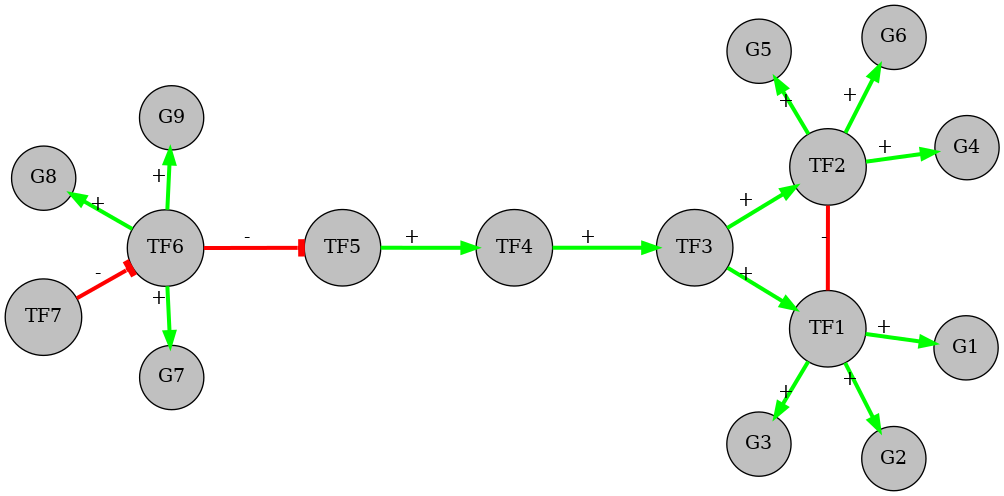

In [9]:
network_fname="boolean-network.bnet"
proc = Popen(f"wget -O {file_folder}/{network_fname} -q {data_url}/{network_fname}".split(" "))
proc.wait()

from NORDic.UTILS.utils_grn import solution2influences
from NORDic.UTILS.utils_plot import influences2graph

with open(f"{file_folder}/{network_fname}", "r") as f:
    ground_truth = pd.DataFrame({
        "Solution": dict([["_".join(g.split("-")) for g in x.split(", ")] for x in f.read().split("\n") if (len(x)>0)])
    })
influences_ground_truth = solution2influences(ground_truth["Solution"])
influences2graph(influences_ground_truth, file_folder+"ground_truth", optional=False, compile2png=True, engine=["sfdp","dot"][0])
from IPython.display import Image
Image(filename=file_folder+'ground_truth.png') 